### Try to downsample first, then frequency offset before correlation, result in corr ~ 0.4

In [76]:
import numpy as np
import scipy
import csv
import matplotlib.pyplot as plt
from py3gpp import *

In [114]:
input_file = '/home/chatchamon/workarea/IQ_constellation/iq_python/input/IQDataFile_SPEEDTEST_10MS.csv'
# input_file = '/home/chatchamon/workarea/IQ_constellation/iq_python/input/IQDataFile_SPOTIFY2.csv'

with open(input_file, 'r') as f:
    reader = csv.reader(f)
    for _ in range(19):
        next(reader)

    iq_val = []
    for row in reader:
        i_val = float(row[0])
        q_val = float(row[1])
        iq_val.append(complex(i_val,q_val))     # I+jQ

    waveform_csv = np.array(iq_val[:230401])    # 10 ms
    # waveform_csv = np.array(iq_val)

print('len_waveform_csv', len(waveform_csv), 'waveform_csv', waveform_csv)

len_waveform_csv 230401 waveform_csv [-0.00123117-0.00102036j  0.00109794-0.00055222j  0.00108245-0.00025547j
 ... -0.00217325+0.00065244j -0.00204915-0.00105801j
 -0.00108961-0.00154664j]


In [115]:
# downsampling, low pass filter
dec_factor = 8
waveform = scipy.signal.decimate(waveform_csv, dec_factor, ftype='fir')
# print("waveform after decimate:",waveform[:5])

# scale up max amplitude to 1
waveform /= max(waveform.real.max(), waveform.imag.max())
# print("waveform scale max amplitude to 1:",waveform[:5])
print('len_waveform', len(waveform), 'waveform', waveform)

sampleRate = 23.04e6
sampleRateDS = sampleRate // dec_factor     # floor devision   

len_waveform 28801 waveform [ 0.16179951-0.23512766j  0.19998263-0.167384j   -0.05051995+0.30468921j
 ...  0.40895248-0.09217698j -0.41135963-0.26136865j
 -0.27107295-0.12754564j]


### Try to do code, may miss some step

In [149]:
scsSSB = 30
searchBW = 6*scsSSB

# shift by half scs step
fshifts = np.arange(-searchBW, searchBW+scsSSB, scsSSB)*1e3/2
print('len_fshifts', len(fshifts), 'fshifts:', fshifts)

t = np.arange(len(waveform))/sampleRateDS
# print('len_t', len(t),'t',t)

# loop on fshifts
coarseFrequencyOffset = fshifts[4]
print('coarseFrequencyOffset:', coarseFrequencyOffset)

# shift frequency by coarseFrequencyOffset
rxWaveformFrquencyCorrect = waveform*np.exp(-1j*2*np.pi*coarseFrequencyOffset*t)
print('rxWaveformFrquencyCorrect:', rxWaveformFrquencyCorrect, 'rxWaveformFrquencyCorrect.shape', rxWaveformFrquencyCorrect.shape)

len_fshifts 13 fshifts: [-90000. -75000. -60000. -45000. -30000. -15000.      0.  15000.  30000.
  45000.  60000.  75000.  90000.]
coarseFrequencyOffset: -30000.0
rxWaveformFrquencyCorrect: [ 0.16179951-0.23512766j  0.21050189-0.15394613j -0.08985767+0.29548838j
 ...  0.39342232-0.1447674j  -0.4275732 -0.23390483j
 -0.27107295-0.12754564j] rxWaveformFrquencyCorrect.shape (28801,)


In [150]:
nSlot = 0
T = len(rxWaveformFrquencyCorrect)

carrier = nrCarrierConfig(NSizeGrid = nrbSSB, SubcarrierSpacing = scsSSB)
info = nrOFDMInfo(carrier)
Nfft = info['Nfft']
slotGrid = nrResourceGrid(carrier)

# loop on NID2
NID2 = 1
slotGrid = slotGrid[:,1]
slotGrid[kPSS] = nrPSS(NID2)
# print('slotGrid[56:59]',slotGrid[56:59])

[refWaveform, info] = nrOFDMModulate(carrier, slotGrid, scsSSB, nSlot, Nfft, SampleRate=sampleRateDS)
refWaveform = refWaveform[info['CyclicPrefixLengths'][0]:]; # remove CP
# print(ref, ref.shape)

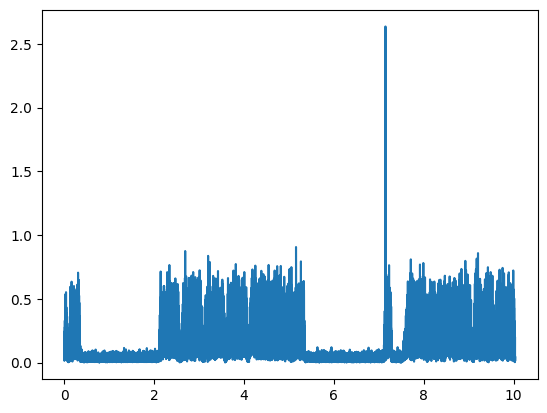

In [151]:
temp = scipy.signal.correlate(rxWaveformFrquencyCorrect, refWaveform)
t_corr = np.arange(temp.shape[0])/sampleRateDS*1e3
plt.plot(t_corr, np.abs(temp))